<img src='../img/joint_school_banner_2.png' alt='joint school banner' align='right' width='100%'></img>

<br>

# Metop-A GOME-2 tropospheric O<sub>3</sub> longterm time-series

### About

The Global Ozone Monitoring Experiment 2 (GOME-2) is an optical spectrometer used for the long-term monitoring of atmospheric trace gas constituents. The GOME-2 instrument has been in orbit on Metop-A since October 2006 until 2020. 

This workflow shows how to produce a longterm time-series of tropospheric O<sub>3</sub>  based on Metop-A GOME-2 Level 3 data between 2007 and 2017, subsetted by different regions. 

Find more information about instrument in the [GOME-2 O3 (and other trace gases) Product User guides](https://acsaf.org/docs/pum/Product_User_Manual_NTO_OTO_DR_GDP48_Jun_2017.pdf) and the Level 3 data on the [AC SAF website](https://acsaf.org/datarecords/o3_vcd.php).

### Basic Facts

> **Spatial resolution**: `2.5° x 1.25°` <br>
> **Spatial coverage**: `Tropics, between 20°S and 20°N` <br>
> **Temporal resolution**:  `Monthly` <br>
> **Temporal coverage**: `since 2007 to 2020` <br>
> **Data format**: `NetCDF`


### How to access the data

The GOME-2 Level 3 tropospheric  O<sub>3</sub> data can be downloaded `via FTP` using this [download URL](ftp://acsaf.eoc.dlr.de). You can use an FTP client such as [FileZilla](https://filezilla-project.org/) to access the files. 

You need to first [register for an account](https://acsaf.org/registration_form.html) with AC SAF and log-in using the credentials you will receive in an email after registration.

### Module outline
- [Define a list with dictionaries holding bounding boxes for different regions](#region_list_ozone)
- [Load Metop-A GOME-2 Level 3 data from January 2007 to December 2020](#level3_ozone)
- [Create (longterm) spatial mean of tropospheric  O<sub>3</sub>](#longterm_mean_ozone)
- [Visualize (longterm) tropospheric  O<sub>3</sub>](#visualize_ozone)
 - [Plot tropospheric  O<sub>3</sub> time-series (2007 to 2020) for the Tropics average, Southern Tropics and part of Southeast Asia](#plot_level3_ts_ozone)
 - [Plot longterm tropospheric  O<sub>3</sub> climatology for the Tropics average, Southern Tropics and part of Southeast Asia](#plot_climatology_ozone)

#### Load required libraries

In [1]:
import os
import glob

import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.axes import Axes

from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='region_list_ozone'></a>Define a list with dictionaries holding bounding boxes for different regions

You can define several regions as a dictionary, e.g. the bounding box information for a `Tropics average`, `Southern Tropics` and `Northern Tropics`. The dictionaries are stored in a list.

In [3]:
# Tropics extent
tropics_extent={'name': 'tropics_extent',
            'lonmin':-180.0,
            'lonmax':180.0,
            'latmin':-20.0,
            'latmax':20.0}

# Southern Tropics extent
st_extent={'name': 'st_extent',
            'lonmin':-180.0,
            'lonmax':180.0,
            'latmin':-20.0,
            'latmax':0}

# Northern Tropics extent
nt_extent={'name': 'nt_extent',
            'lonmin':-180.0,
            'lonmax':180.0,
            'latmin':0,
            'latmax':20.0}

region_list=[tropics_extent,
             st_extent,
             nt_extent]

## <a id='level3_ozone'></a>Load Metop-A GOME-2 Level 3 data from January 2007 to December 2020

Global Metop-A GOME-2 Level 3 data are available from January 2007 to December 2020. From this longterm time-series, you can create a spatial average of a specific region and visualize the monthly tropospheric  O<sub>3</sub> content over time.

#### Load the Metop-A GOME-2 Level 3 data files as `xarray.DataArray` with the function `xarray.open_mfdataset()`

The Metop-A GOME-2 Level 3 data are disseminated in `netCDF`. The function `xarray.open_mfdataset()` can be used to load the data for all months at once. Use `time` for the keyword argument `concat_dim`.

In [4]:
gome_l3 = xr.open_mfdataset('../../eodata/training_school/gome2/level3/o3tropo-metop-a/*.nc', concat_dim='time', combine='nested',  group='PRODUCT')
gome_l3

<xarray.Dataset>
Dimensions:                          (time: 166, latitude: 32, longitude: 144)
Dimensions without coordinates: time, latitude, longitude
Data variables:
    tropospheric_O3                  (time, latitude, longitude) float32 dask.array<chunksize=(1, 32, 144), meta=np.ndarray>
    tropospheric_O3_std              (time, latitude, longitude) float32 dask.array<chunksize=(1, 32, 144), meta=np.ndarray>
    tropospheric_O3_number           (time, latitude, longitude) float64 dask.array<chunksize=(1, 32, 144), meta=np.ndarray>
    tropospheric_O3_mixingratio      (time, latitude, longitude) float32 dask.array<chunksize=(1, 32, 144), meta=np.ndarray>
    tropospheric_O3_mixingratio_std  (time, latitude, longitude) float32 dask.array<chunksize=(1, 32, 144), meta=np.ndarray>

Above, you can see that the `xarray.Dataset` has three dimensions (`latitude`, `longitude` and `time`), but the dimensions do not have coordinates. However, the coordinate information is required for plotting.

Thus, as a next step, you can load one single Metop-A GOME-2 Level 3 file and retrieve the `latitude` and `longitude` coordinates. You can use this information to assign the coordinates to the `xarray.Dataset` above.

In [5]:
ds = xr.open_dataset('../../eodata/training_school/gome2/level3/o3tropo-metop-a/GOME_O3tropo_Tropics_200701_METOPA_DLR_v1.nc')
ds, ds.latitude, ds.longitude

(<xarray.Dataset>
 Dimensions:    (latitude: 32, longitude: 144)
 Coordinates:
   * latitude   (latitude) float32 -19.38 -18.12 -16.88 ... 16.88 18.12 19.38
   * longitude  (longitude) float32 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
 Data variables:
     *empty*
 Attributes:
     institution:  DLR Deutsches Zentrum fuer Luft und Raumfahrt
     reference:    http://atmos.eoc.dlr.de/gome/gto-ecv.html
     source:       space borne remote sensing
     title:        tropical tropospheric ozone column data,
 <xarray.DataArray 'latitude' (latitude: 32)>
 array([-19.375, -18.125, -16.875, -15.625, -14.375, -13.125, -11.875, -10.625,
         -9.375,  -8.125,  -6.875,  -5.625,  -4.375,  -3.125,  -1.875,  -0.625,
          0.625,   1.875,   3.125,   4.375,   5.625,   6.875,   8.125,   9.375,
         10.625,  11.875,  13.125,  14.375,  15.625,  16.875,  18.125,  19.375],
       dtype=float32)
 Coordinates:
   * latitude  (latitude) float32 -19.38 -18.12 -16.88 ... 16.88 18.12 19.38
 Attribut

#### Assign coordinates to the dimensions `latitude`, `longitude` and `time`

You can use the function `pandas.date_range` from the pandas library to build a list of monthly time coordinates from January 2007 to December 2020.

In [6]:
# Build list of time coordinates with pandas
time_coords = pd.date_range('2007-01', '2020-12', freq='MS').strftime("%Y-%m").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=168, freq=None)

Note that two data files are missing, from `2020-02-01` and `2019-04-01`. First, you need to find the locations of these two date elements in the `DateTimeIndex`. Then, you need to remove these two dates from the `DateTimeIndex` using the `delete` method. 

In [7]:
time_coords.get_loc('2020-02-01')

157

In [8]:
time_coords_2 = time_coords.delete(157)
time_coords_2

DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=167, freq=None)

In [9]:
time_coords_2.get_loc('2019-04-01')

147

In [10]:
time_coords_3 = time_coords_2.delete(147)
time_coords_3

DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=166, freq=None)

Use the function `xarray.assign_coords()` to assign `latitude`, `longitude` and `time` coordinates to the `gome_l3` `xarray.Dataset` above.

In [11]:
# Assign values to Dataset dimension
gome_l3_assigned = gome_l3.assign_coords(latitude=ds.latitude, longitude=ds.longitude, time=time_coords_3)
gome_l3_assigned

<xarray.Dataset>
Dimensions:                          (time: 166, latitude: 32, longitude: 144)
Coordinates:
  * latitude                         (latitude) float32 -19.38 -18.12 ... 19.38
  * longitude                        (longitude) float32 -178.8 -176.2 ... 178.8
  * time                             (time) datetime64[ns] 2007-01-01 ... 202...
Data variables:
    tropospheric_O3                  (time, latitude, longitude) float32 dask.array<chunksize=(1, 32, 144), meta=np.ndarray>
    tropospheric_O3_std              (time, latitude, longitude) float32 dask.array<chunksize=(1, 32, 144), meta=np.ndarray>
    tropospheric_O3_number           (time, latitude, longitude) float64 dask.array<chunksize=(1, 32, 144), meta=np.ndarray>
    tropospheric_O3_mixingratio      (time, latitude, longitude) float32 dask.array<chunksize=(1, 32, 144), meta=np.ndarray>
    tropospheric_O3_mixingratio_std  (time, latitude, longitude) float32 dask.array<chunksize=(1, 32, 144), meta=np.ndarray>

## <a id='longterm_mean_ozone'></a> Create (longterm) spatial mean of tropospheric  O<sub>3</sub>

Let us loop through the list of regions and create a dictionary containing two lists:
- **o3tropo_l3**: the spatial average for each month of tropospheric  O<sub>3</sub> of the specific region, and
- **o3tropo_monthly_avg**: the longterm mean of tropospheric  O<sub>3</sub> of each month
- **o3tropo_yearly_avg**: the annual mean of tropospheric O<sub>3</sub> of each year

The loop makes use of the function [generate_geographical_subset](../functions.ipynb#geographical_subset), which creates a smaller spatial subset based on the bounding box information of each region.

The spatial average of a `xarray.DataArray` is computed with the function `xarray.DataArray.mean()` and specifying the dimension to apply the spatial average with `dim=['latitude', 'longitude']`.

The longterm average is retrieved by using xarray's `groupby('time.month').mean()` aggregator.

In [12]:
# Retrieve the tropospheric O3 from the xarray Dataset
o3tropo_l3 = gome_l3_assigned.tropospheric_O3

# Initialise an empty dictionary
gome2_l3_dict = {}

# Loop through each item in region list
for region in region_list:
    print(region)
    # Generate a geographical subset
    tmp = generate_geographical_subset(xarray=o3tropo_l3,
                                       latmin=region['latmin'],
                                       latmax=region['latmax'],
                                       lonmin=region['lonmin'],
                                       lonmax=region['lonmax'])
    
    # Create the spatial average of the region
    tmp_mean = tmp.mean(dim=['latitude','longitude'])
    # Create the longterm climatology of each month
    tmp_climatology_mean = tmp_mean.groupby('time.month').mean()
    # Fill the dictionary with the two lists
    gome2_l3_dict[region['name']]={'o3tropo_l3':tmp_mean,
                                   'o3tropo_monthly_avg': tmp_climatology_mean}
    # Create the annual average of each year
    tmp_annual_mean = tmp_mean.groupby('time.year').mean()
    # Fill the dictionary with the lists
    gome2_l3_dict[region['name']]={'o3tropo_l3':tmp_mean,
                                   'o3tropo_monthly_avg': tmp_climatology_mean,
                                   'o3tropo_yearly_avg': tmp_annual_mean}


{'name': 'tropics_extent', 'lonmin': -180.0, 'lonmax': 180.0, 'latmin': -20.0, 'latmax': 20.0}
{'name': 'st_extent', 'lonmin': -180.0, 'lonmax': 180.0, 'latmin': -20.0, 'latmax': 0}
{'name': 'nt_extent', 'lonmin': -180.0, 'lonmax': 180.0, 'latmin': 0, 'latmax': 20.0}


The resulting dictionary contains the three regions as keys and for each region, you can retrieve the time series and climatology of tropospheric  O<sub>3</sub>.

In [13]:
gome2_l3_dict['nt_extent']['o3tropo_l3']

<xarray.DataArray 'tropospheric_O3' (time: 166)>
dask.array<mean_agg-aggregate, shape=(166,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01 2007-02-01 ... 2020-12-01

## <a id='visualize_ozone'></a>Visualize (longterm) tropospheric  O<sub>3</sub> 

### <a id='plot_level3_ts_ozone'></a>Plot tropospheric  O<sub>3</sub> time-series (2007 to 2020) for a Tropics average, Southern Tropics and Northern Tropics.

Let us visualize the tropospheric  O<sub>3</sub> time-series from 2007 to 2017. You can make use of the `xarray.DataArray.plot.line()` function. As dictionary key, you select for each region the `o3tropo_l3` time-series.

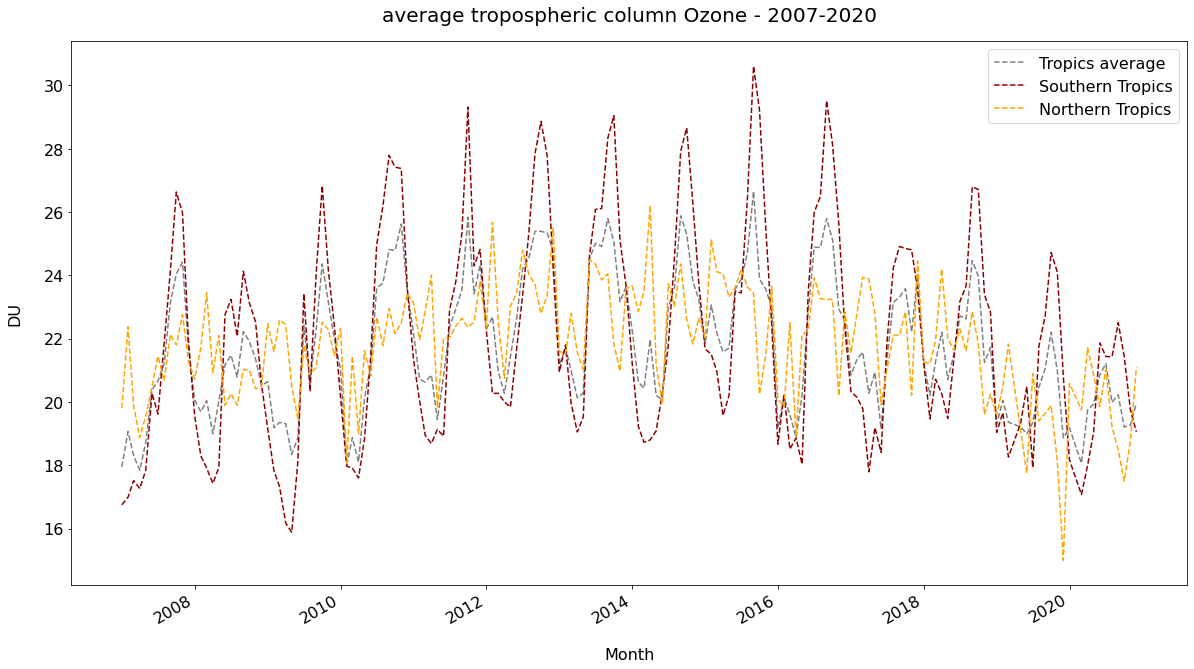

In [14]:
fig = plt.figure(figsize=(20,10))

(gome2_l3_dict['tropics_extent']['o3tropo_l3']).plot.line(
    linestyle='dashed',
    color='grey', 
    label='Tropics average')

(gome2_l3_dict['st_extent']['o3tropo_l3']).plot.line(
    linestyle='dashed',
    color='darkred', 
    label='Southern Tropics')

(gome2_l3_dict['nt_extent']['o3tropo_l3']).plot.line(
    linestyle='dashed',
    color='orange',
    label='Northern Tropics')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(o3tropo_l3.long_name + " Ozone - 2007-2020", fontsize=20, pad=20)
plt.ylabel(o3tropo_l3.units + '\n', fontsize=16)
plt.xlabel('\nMonth', fontsize=16)
plt.legend(fontsize=16,loc=0)
plt.show()

### <a id='plot_climatology_ozone'></a> Plot longterm tropospheric  O<sub>3</sub> climatology for a Tropics average, Southern Tropics and Northern Tropics.

Let us visualize the longterm tropospheric  O<sub>3</sub> climatology for each month (based on the 2007 to 2020 time-series). You can make use of the `xarray.DataArray.plot.line()` function. As dictionary key, you select for each region the `o3tropo_monthly_avg` time-series.

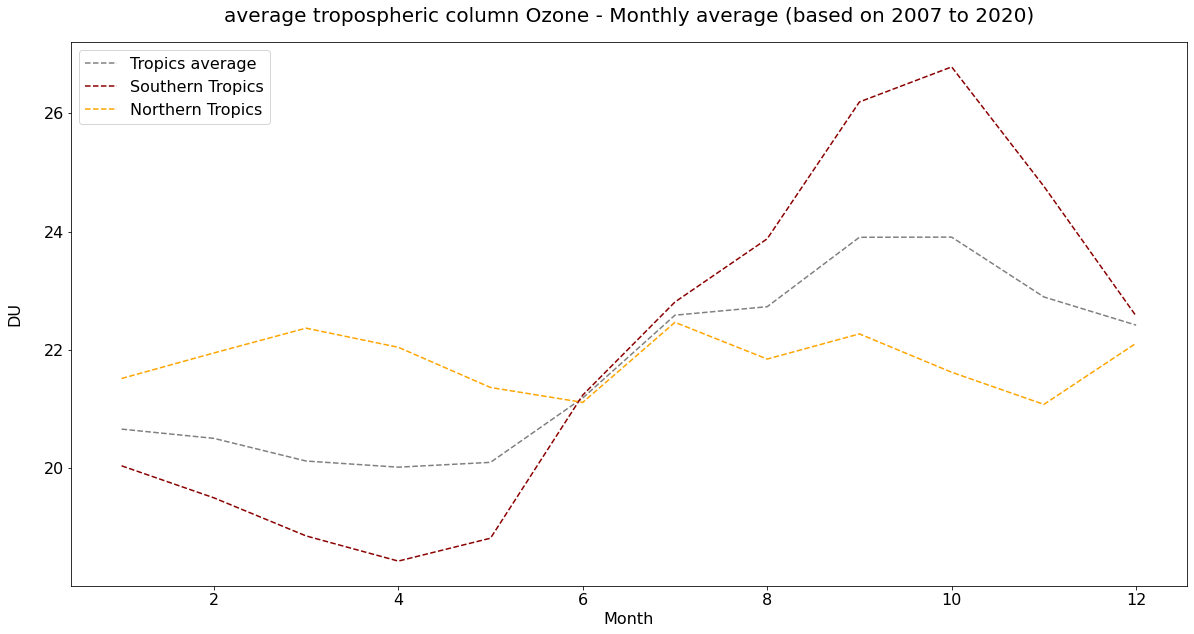

In [15]:
fig = plt.figure(figsize=(20,10))

(gome2_l3_dict['tropics_extent']['o3tropo_monthly_avg']).plot.line(
    linestyle='dashed',
    color='grey', 
    label='Tropics average')

(gome2_l3_dict['st_extent']['o3tropo_monthly_avg']).plot.line(
    linestyle='dashed',
    color='darkred', 
    label='Southern Tropics')

(gome2_l3_dict['nt_extent']['o3tropo_monthly_avg']).plot.line(
    linestyle='dashed',
    color='orange', 
    label='Northern Tropics')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(o3tropo_l3.long_name + " Ozone - Monthly average (based on 2007 to 2020)", fontsize=20, pad=20)
plt.ylabel(o3tropo_l3.units + '\n', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.legend(fontsize=16,loc=2)
plt.show()

## <a id='visualize_bar_plot_ozone'></a>Visualize Tropics average annual time-series of ozone mixing ratio values from 2007 to 2020 as a bar plot

First, you can convert the xarray.DataArray with the annual mean climatology into a Pandas series using `.to_series`. This enables you to plot the data as a bar plot with the function `plot.bar()`.

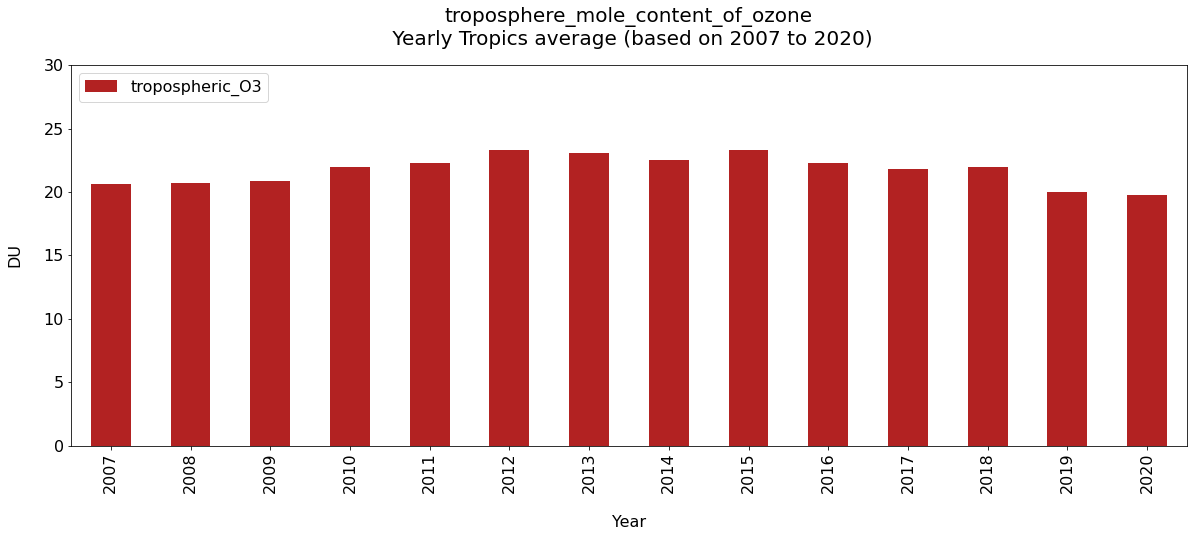

In [16]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20,7))

o3tropo_series = (gome2_l3_dict['tropics_extent']['o3tropo_yearly_avg']).to_series()

o3tropo_series.plot.bar( 
    ax=ax, 
    color='firebrick')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_ylim(0, 30)

plt.title(o3tropo_l3.standard_name + "\n Yearly Tropics average (based on 2007 to 2020)", fontsize=20, pad=20)
plt.ylabel(o3tropo_l3.units + '\n' , fontsize=16)
plt.xlabel('\nYear', fontsize=16)
plt.legend(fontsize=16,loc=2)
plt.show()

<br>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a>.</p>